## _*Using QISKit ACQUA algorithms, a how to guide*_

This notebook demonstrates how to use the `QISKit ACQUA` library to invoke a specific algorithm and process the result.

Further information is available for the algorithms in the github repo qiskit_acqua/readme.md

In [67]:
from qiskit_acqua import Operator, run_algorithm
from qiskit_acqua.input import get_input_instance
from qiskit.tools.apps.optimization import Hamiltonian_from_file, make_Hamiltonian
import matplotlib.pyplot as plt
from ckalgomethods import get_algorithm_ck
import numpy as np
from qiskit_acqua.utils.variational_forms.ryspecialdw import VarFormRYSpecialDW
from qiskit_acqua.utils.variational_forms.ryspecialdwo import VarFormRYSpecialDWO
from qiskit_acqua.utils.variational_forms.ryspecial import VarFormRYSpecial
from qiskit_acqua.utils.variational_forms.ryspecialfull import VarFormRYSpecialFull
from qiskit_acqua.utils.variational_forms.ryspecialfull2 import VarFormRYSpecialFull2
from qiskit_acqua.utils.variational_forms.ryspecialfull3 import VarFormRYSpecialFull3
from qiskit_acqua.utils.variational_forms.ryspecialpi import VarFormRYSpecialPi
from qiskit_acqua.utils.variational_forms.u3dw import VarFormU3DW
from qiskit import QuantumCircuit, ClassicalRegister, execute
from Jupyter_Code import circuitImage
import getpass, time
from qiskit import available_backends, register, get_backend
%matplotlib notebook

In [68]:
##### INPUTS
ham_name = 'doubled_double_well_fixed.txt' #'doubled_harmonic_fixed.txt' #'doubled_double_well_small.txt' #'doubled_anharmonic_small.txt' #'doubled_anharmoniccor.txt' #'doubled_anharmonic.txt' #'harmonic_pi_measurement.txt' #'doubled_harmonic.txt' #'harmonic_fermion.txt' #'anharmonic_osc.txt' #'anharmonic_NR.txt' # 'double_well.txt' # 'qho_3qubits_test.txt' # 'double_well5qcor.txt'
circuit_name = 'RYSpecialFull3' # RYSpecialFull3 # RYSpecialFull2 # RYSpecialFull # RYSpecial # 'RY' # 'RYRZ' # RYSpecialDW # U3DW # RYSpecialDWO
depth = 3 # 3 seems ok, although can be decreased with more shots
shots = 8192 # 8192 or 16384 seems to work ok #### 10000 works for anharmonic
optimizer_name = 'SPSA' # 'L_BFGS_B' # 'SPSA' # 'SAN'
backend_name = 'local_qasm_simulator' #'ibmq_qasm_simulator' # 'local_statevector_simulator' # 'local_qasm_simulator'
maxfun = 1000 # for LBFGSB optimizer, 1000 seems fine
max_trials = 70 # for SPSA optimizer #### 30 works for anharmonic
starting_temperature = 20
time_constant = 35
step_frac = .03
window_size = 1 # number in average for obj_fun calc in SAN. More for stdev greater percent of energy

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from a previously computed Hamiltonian for simplicity

In [69]:
# this is the actual loading
qubitOp = Operator.load_from_file(ham_name)
# just to display hamiltonian, not actually important for the calculation
#qubitOp.matrix

We can now use the Operator without regard to how it was created. First we need to prepare the configuration params to invoke the algorithm. Here we will use the ExactEigensolver first to return the smallest eigenvalue. Backend is not required since this is computed classically not using quantum computation. We then add in the qubitOp Operator in dictionary format. Now the complete params can be passed to the algorithm and run. The result is a dictionary.

In [70]:
# Find the exact energy
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'algorithm': algorithm_cfg
}
algo_input = get_input_instance('EnergyInput')
algo_input.qubit_op = qubitOp
result_exact = run_algorithm(params,algo_input)
exact_energy = result_exact['energies'][0]
print(result_exact)

{'eigvals': array([-1.74176735e-15-9.98192693e-17j]), 'eigvecs': array([[-8.18999864e-02+1.47799553e-01j, -9.43663636e-17-7.66438935e-17j,
        -1.22873198e-01+1.00521688e-01j, -2.54869038e-16-2.40491740e-16j,
        -1.87941614e-16+1.60677497e-16j, -3.26068755e-01-5.40035337e-01j,
        -1.74504332e-16-2.71609848e-16j,  1.68940464e-03+2.28312058e-01j,
        -1.22873198e-01+1.00521688e-01j, -3.90330467e-16-3.99829494e-16j,
        -6.11858078e-02+1.30853431e-01j, -1.63406041e-16-2.01209375e-16j,
        -1.78282100e-16-3.53523442e-16j,  1.68940464e-03+2.28312058e-01j,
        -1.94118379e-16-1.21882472e-16j, -3.26068755e-01-5.40035337e-01j]]), 'energy': -1.7417673463423241e-15, 'wavefunction': array([[-8.18999864e-02+1.47799553e-01j, -9.43663636e-17-7.66438935e-17j,
        -1.22873198e-01+1.00521688e-01j, -2.54869038e-16-2.40491740e-16j,
        -1.87941614e-16+1.60677497e-16j, -3.26068755e-01-5.40035337e-01j,
        -1.74504332e-16-2.71609848e-16j,  1.68940464e-03+2.28312058

In [71]:
if optimizer_name == 'SAN':
    plt.figure(93084858850968983)
    time_array = list(range(max_trials))
    plt.plot([starting_temperature*np.exp(-t/time_constant) for t in time_array])
    plt.ylabel('Temperature')
    plt.xlabel('Annealing Step')
    plt.title('final = {}'.format(starting_temperature*np.exp(-time_array[-1]/time_constant)))
    plt.show()
    
    plt.figure(3349400329939)
    step_array = [2*np.pi*step_frac/(1+np.exp((t-max_trials+1)/50)) for t in time_array] 
    plt.plot(step_array)
    plt.ylabel('Step Size')
    plt.xlabel('Annealing Step')
    plt.title('final = {}'.format(step_array[-1]))
    plt.show()

Now we want VQE and so change it and add its other configuration parameters. VQE also needs and optimizer and variational form. While we can omit them from the dictionary, such that defaults are used, here we specify them explicitly so we can set their parameters as we desire.

In [72]:
# stuff for actually running it
if 'local' not in backend_name:
    APItoken = '558a0344c2f76f867385b920cb79e342dd809a41d416d011338bc2cc6437dfb852272f5e3ef73d245d41cd4431969f10c22117e1aaf60a490ae4a605fc542f1b'  
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}

    try:
        register(qx_config['APItoken'], qx_config['url'])

        print('\nYou have access to great power!')
        print(available_backends({'local': False, 'simulator': False}))
    except: 
        print('Something went wrong.\nDid you enter a correct token?')

In [73]:
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'#,
    #'initial_point':[1.8]
    #'initial_point': [-1.03950031,0.80118571,1.06668076,0.88260114,0.49424101,-3.06401698,-1.13659464]
    #'initial_point': [2.9,-2.5,-1.4,-.64,.91,3.1,.11,3.4,.85,-1.2,2,3.9,1.6,1.4]
    #'initial_point': [2.74779212,1.66499758,-2.85117075,-1.14934467,3.47893086,0.66102871,-0.4205614,-0.44878755]
}


if optimizer_name == 'L_BFGS_B':
    optimizer_cfg = {
        'name': 'L_BFGS_B',
        'maxfun': maxfun
    }
    
if optimizer_name == 'SPSA':
    optimizer_cfg = {
        'name': 'SPSA', 
        'max_trials': max_trials,
        'save_steps': 1
    }
    
if optimizer_name == 'SAN':
    optimizer_cfg = {
        'name': 'SAN', 
        'max_trials': max_trials,
        'save_steps': 1,
        'starting_temperature': starting_temperature,
        'time_constant': time_constant,
        'step_frac': step_frac,
        'window_size': window_size
    }
    

var_form_cfg = {
    'name': circuit_name,
    'depth': depth,
    'entanglement': 'linear'
}

backend_cfg = {
    'name': backend_name, 
    'shots': shots
}

params = {
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': backend_cfg
}

SPSA QASM predicted time to completion: 2.0 min
Exact = -1.7417673463423241e-15
VQE = 0.02327115400853419
Percent Error = 1336065580595759.75%
Evaluation Time = 0.8 min
Optimal Parameters: 
[-0.8987352491613605, -3.261250073254609, -0.0016183697460306152, 1.9833365539083836, -0.10931741597511904, -2.144820148893621, -0.984148060278891, -2.5691532180181635, 0.8380300136010812, 3.7694378522123566, 1.2039334721514072, -1.0536988818596833]


<IPython.core.display.Javascript object>


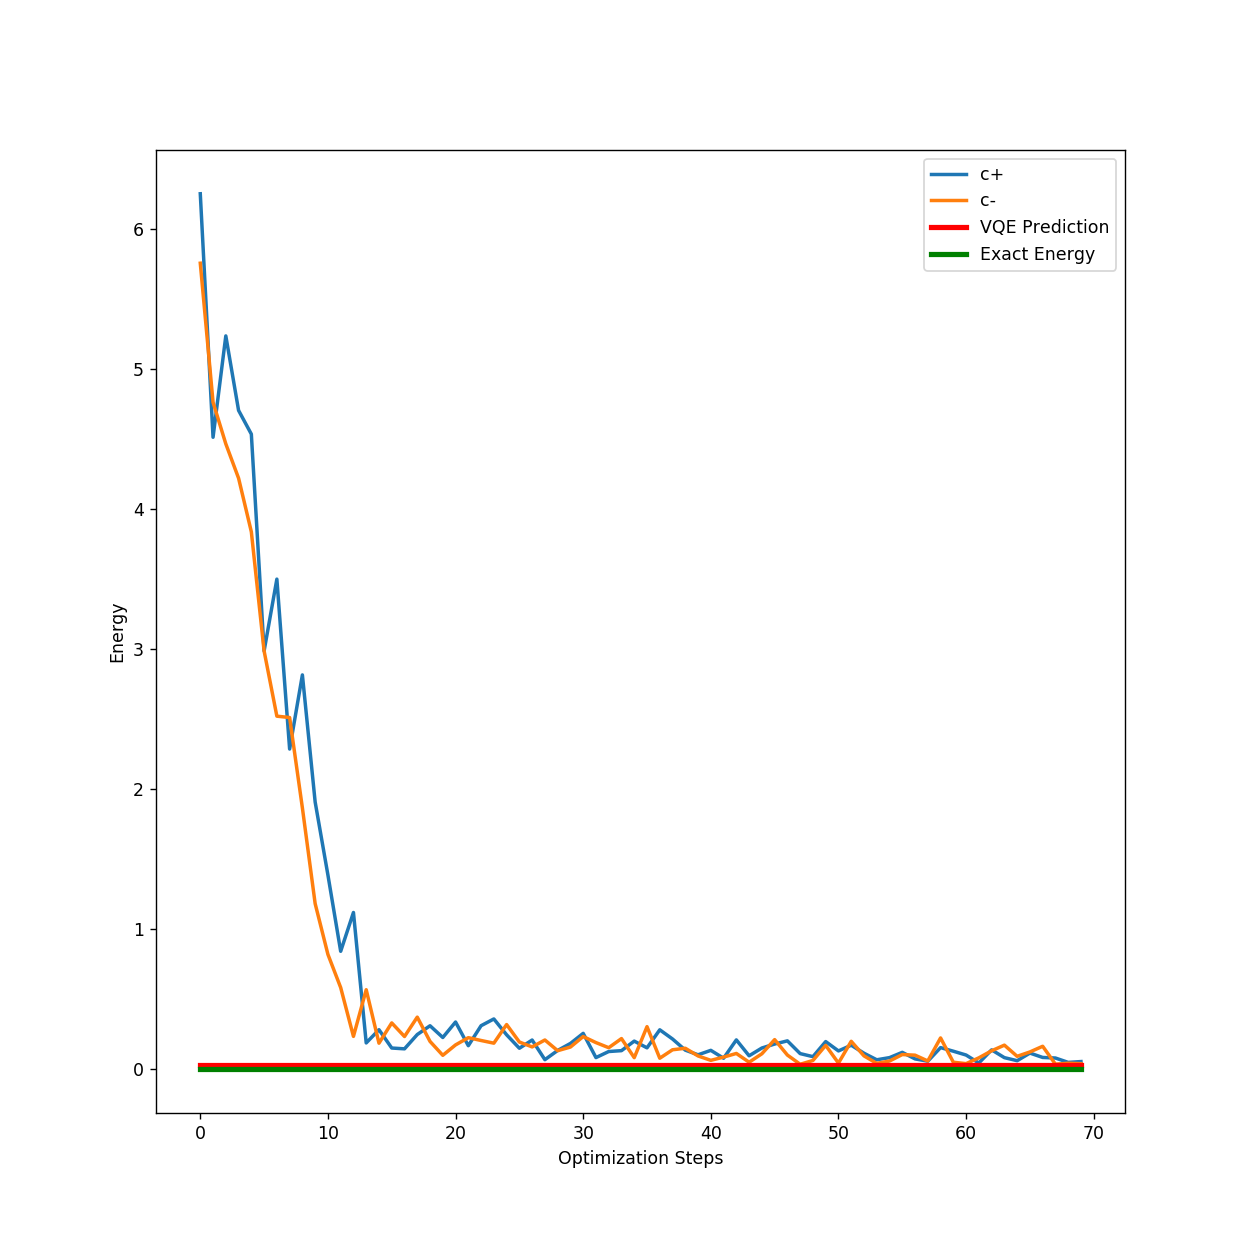

In [74]:
# Use the VQE to find the energy
if backend_name == 'local_statevector_simulator' and optimizer_name == 'SPSA':
    print('SPSA STATEVECTOR predicted time to completion: {:3.1f} min'.format((2.3e-5)*shots*max_trials/60))
    
if backend_name == 'local_qasm_simulator' and optimizer_name == 'SPSA':
    print('SPSA QASM predicted time to completion: {:3.1f} min'.format((2.1e-4)*shots*max_trials/60))
    
if backend_name == 'local_qasm_simulator' and optimizer_name == 'SAN':
    print('SAN QASM predicted time to completion: {:3.1f} min'.format(0.056*max_trials + 1.3)) # 0.056 min / step, 1.3 base min
    
result_vqe = run_algorithm(params,algo_input)
exact_energy = result_exact['energies'][0]
vqe_energy = result_vqe['energy']
print('Exact = {}'.format(exact_energy))
print('VQE = {}'.format(vqe_energy))
print('Percent Error = {:5.2f}%'.format(abs((vqe_energy-exact_energy)/exact_energy)*100))
print('Evaluation Time = {:3.1f} min'.format(result_vqe['eval_time']/60)) 
print('Optimal Parameters: ')
print(list(result_vqe['opt_params']))
# Roughly 2.3e-5 s / shot at 4 qubits and depth 3 for local_statevector_simulator. 
# Roughly 2.1e-4 s / shot at 4 qubits and depth 3 for local_qasm_simulator. Seems to scale more with loops than shots.
# 1.7e-6 min / shot, 0.029 min / loop at 4 qubits, depth 3 for local_qasm_simulator. This prediction should scale better.

# Show convergence
plt.figure(902734,figsize=(10,10))
plt.plot(result_vqe['cplus'],label='c+',linewidth=2)
plt.plot(result_vqe['cminus'],label='c-',linewidth=2)
plt.plot(vqe_energy*np.ones(np.array(result_vqe['cminus']).shape),color='r',label='VQE Prediction',linewidth=3)
plt.plot(exact_energy*np.ones(np.array(result_vqe['cminus']).shape),color='g',label='Exact Energy',linewidth=3)
plt.xlabel('Optimization Steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [75]:
# Now that we have optimized algorithm, time to find prediction for the energy
print('Retrieving algorithm...')
vqealg = get_algorithm_ck(params,algo_input)
print('Getting Stats...')
optimal_energies = []
for t in range(500):
    #optimal_energies.append(vqealg._energy_evaluation([5.349789984169478, 1.2984072014815706, -0.015040561391926105, 2.9062833099679835, -3.3299008846256064]))
    optimal_energies.append(vqealg._energy_evaluation(result_vqe['opt_params']))
    #optimal_energies.append(vqealg._energy_evaluation([-0.2162068]))
    #optimal_energies.append(vqealg._energy_evaluation([3.12008457,-1.26280244,-0.19086582,-2.15134405,2.9695784,-1.15651384,-2.01826908]))
    if (t+1) % 20 == 0:
        print('{} Events Made'.format(t+1))
    
print('Finished.')

Retrieving algorithm...
Getting Stats...
20 Events Made
40 Events Made
60 Events Made
80 Events Made
100 Events Made
120 Events Made
140 Events Made
160 Events Made
180 Events Made
200 Events Made
220 Events Made
240 Events Made
260 Events Made
280 Events Made
300 Events Made
320 Events Made
340 Events Made
360 Events Made
380 Events Made
400 Events Made
420 Events Made
440 Events Made
460 Events Made
480 Events Made
500 Events Made
Finished.


<IPython.core.display.Javascript object>


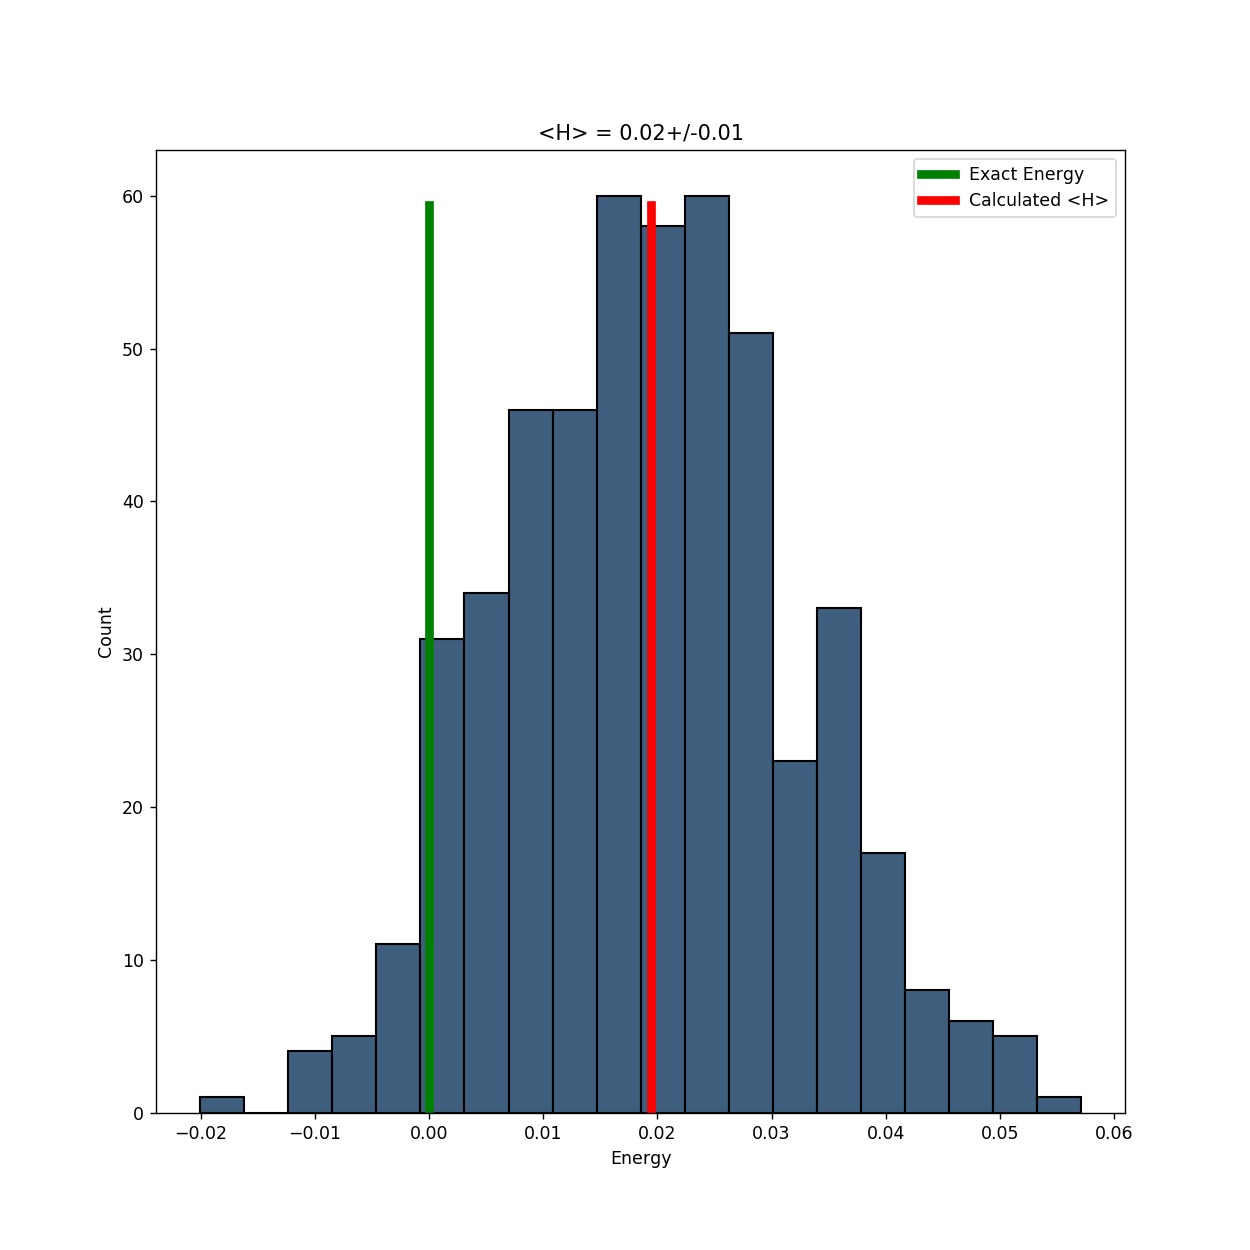

In [76]:
plt.figure(99373665392,figsize=(10,10))
histvals = plt.hist(optimal_energies,20,color="#3F5D7D",edgecolor='black', linewidth=1.2)
plt.title('<H> = {:3.2f}+/-{:3.2f}'.format(np.mean(optimal_energies),np.std(optimal_energies)))
plt.plot([exact_energy for k in range(100)],[max(histvals[0])*k/100 for k in range(100)],color='g',label='Exact Energy',linewidth=5)
plt.plot([np.mean(optimal_energies) for k in range(100)],[max(histvals[0])*k/100 for k in range(100)],color='r',linewidth=5,label='Calculated <H>')
plt.xlabel('Energy')
plt.ylabel('Count')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


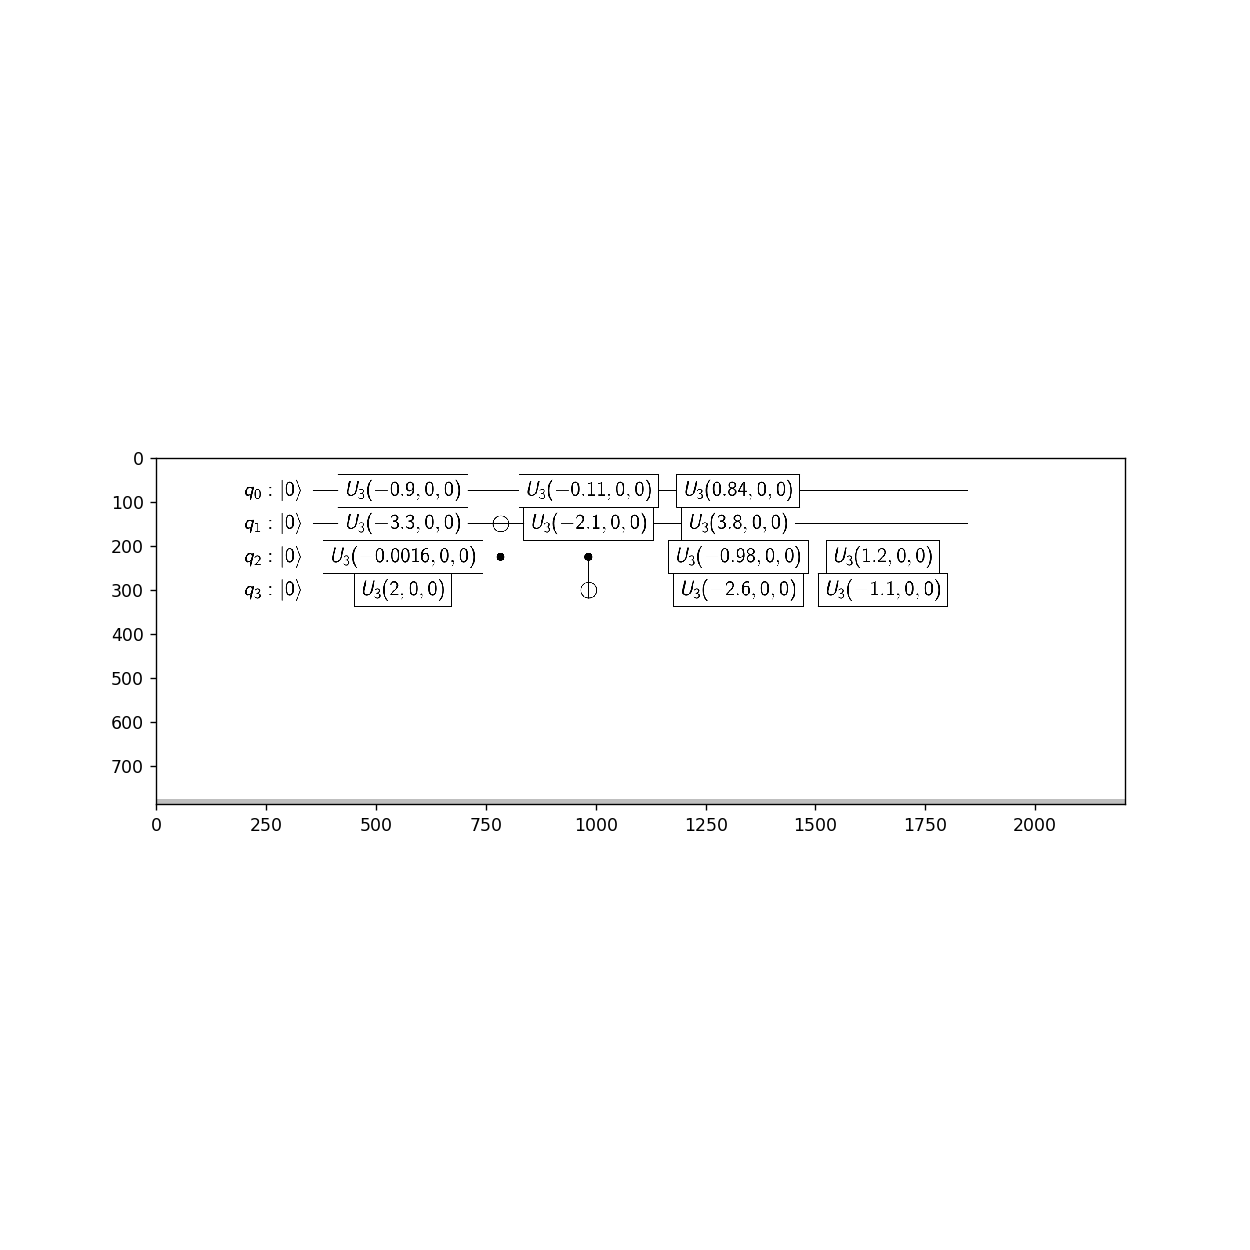

[(0.46187960321405364+0j), (-0.03935986005362219+0j), (-0.4933773874298727+0j), (0.04204399758666513+0j), (0.051135763586248134+0j), (-0.004357621519729831+0j), (-0.05423163941716001+0j), (0.004621441871614066+0j), (-0.4947289742546999+0j), (0.042159175368722046+0j), (0.5285423896172953+0j), (-0.045040643368922884+0j), (-0.05507914356657988+0j), (0.004693663386666699+0j), (0.05773203823836591+0j), (-0.00491973434172056+0j)]


In [77]:
if circuit_name == 'RYSpecialDW':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']
    
    vform = VarFormRYSpecialDW()
    vform.init_args(qubitOp.num_qubits,depth)
    #opt = [2.9,-2.5,-1.2,-1.4,-.64,1.8,.91,3.1,1.2,.11,3.4,-2.9,.85,-1.2,2,3.9,1.6,1.4] # [-1.03950031,0.80118571,1.06668076,0.88260114,0.49424101,-3.06401698,-1.13659464]   
    #opt = [-1.03950031,0.80118571,1.06668076,0.88260114,0.49424101,-3.06401698,-1.13659464]
    #circ = vform.construct_circuit(opt) 
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecial':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecial()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialFull':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialFull()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialFull3':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialFull3()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialFull2':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialFull2()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialPi':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialPi()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'U3DW':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormU3DW()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialDWO':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']
    
    vform = VarFormRYSpecialDWO()
    vform.init_args(qubitOp.num_qubits,depth)
    #opt = [2.9,-2.5,-1.2,-1.4,-.64,1.8,.91,3.1,1.2,.11,3.4,-2.9,.85,-1.2,2,3.9,1.6,1.4]
    #circ = vform.construct_circuit(opt) 
    #opt = [2.9,-2.5,-1.4,-.64,.91,3.1,.11,3.4,.85,-1.2,2,3.9,1.6,1.4]
    #circ = vform.construct_circuit(optimal)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
    
    
# old stuff
#circ.add(c)
    #circ.measure(q, c)
    #e0wf = execute(circ,backend_name,shots=shots)
    #pred = e0wf.result().get_counts(circ)
    #e0wf = np.array([pred[k] if k in pred.keys() else 0 for k in ordering])
    #e0wf = e0wf/np.sqrt(np.dot(e0wf,e0wf))

In [78]:
print(list(e0wf.real))

[0.46187960321405364, -0.03935986005362219, -0.4933773874298727, 0.04204399758666513, 0.051135763586248134, -0.004357621519729831, -0.05423163941716001, 0.004621441871614066, -0.4947289742546999, 0.042159175368722046, 0.5285423896172953, -0.045040643368922884, -0.05507914356657988, 0.004693663386666699, 0.05773203823836591, -0.00491973434172056]


In [79]:
optimal = []
for res in result_vqe['opt_params']:
    while res > 2*np.pi or res < 0:
        if res > 2*np.pi:
            res -= 2*np.pi
        elif res < 0:
            res += 2*np.pi
    optimal.append(res)
optimal = np.array(optimal)
print(optimal)

[5.38445006 3.02193523 6.28156694 1.98333655 6.17386789 4.13836516
 5.29903725 3.71403209 0.83803001 3.76943785 1.20393347 5.22948643]


In [80]:
image.show()

In [27]:
#### Prep to run it on actual qcomp
import getpass, time
from qiskit import available_backends, register, get_backend

#APItoken = getpass.getpass('Please input your token and hit enter: ')
APItoken = '558a0344c2f76f867385b920cb79e342dd809a41d416d011338bc2cc6437dfb852272f5e3ef73d245d41cd4431969f10c22117e1aaf60a490ae4a605fc542f1b'  
qx_config = {
    "APItoken": APItoken,
    "url":"https://quantumexperience.ng.bluemix.net/api"}

try:
    register(qx_config['APItoken'], qx_config['url'])

    print('\nYou have access to great power!')
    print(available_backends({'local': False, 'simulator': False}))
except: 
    print('Something went wrong.\nDid you enter a correct token?')
    
def lowest_pending_jobs():
    """Returns the backend with lowest pending jobs."""
    list_of_backends = available_backends(
        {'local': False, 'simulator': False})
    device_status = [get_backend(backend).status
                     for backend in list_of_backends]
    best = min([x for x in device_status if x['available'] is True],
               key=lambda x: x['pending_jobs'])
    return best['name']

backend = lowest_pending_jobs()
print("The best backend is " + backend)


You have access to great power!
['ibmqx2', 'ibmqx4', 'ibmqx5']
The best backend is ibmqx5


In [6]:
########## Dynamics
qubitOp = Operator.load_from_file('qho_3qubits_test.txt')
evoOp = qubitOp
params = {
    'problem': {
        'name': 'dynamics'
    },
    'algorithm': {
        'name': 'Dynamics',
        'num_time_slices': 1
    },
    'initial_state': {
        'name': 'CUSTOM',
        'state': 'uniform'
    },
    'backend': {
        'name': 'local_statevector_simulator'
    }
}
algo_input = get_input_instance('EnergyInput')
algo_input.qubit_op = qubitOp
algo_input.add_aux_op(evoOp)
ret = run_algorithm(params,algo_input)
print('The dynamics result is\n{}'.format(ret))

The dynamics result is
{'avg': (4.000000000000003-2.498001805406602e-16j), 'std_dev': 0.0}


<IPython.core.display.Javascript object>


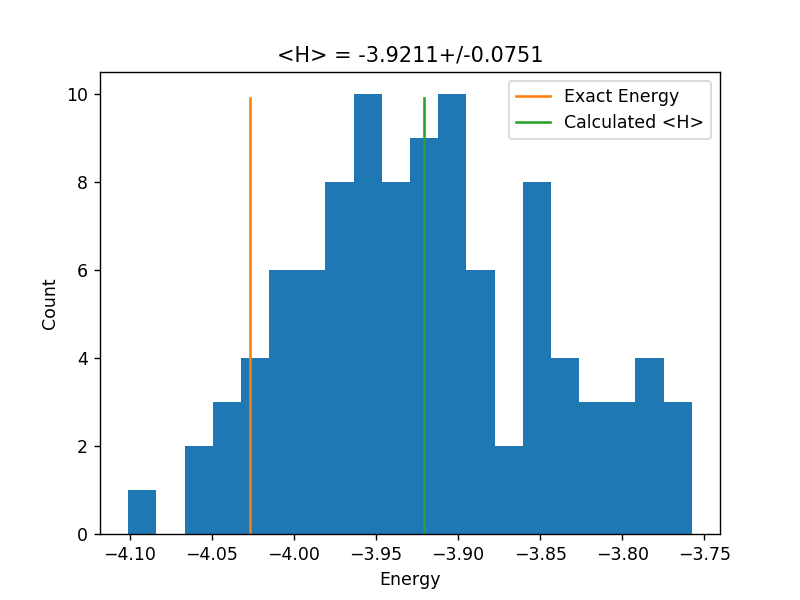

In [22]:
optimal_energies2 = []
params['backend']['shots'] = 16384
vqealg = get_algorithm_ck(params,algo_input)
for t in range(100):
    optimal_energies2.append(vqealg._energy_evaluation(result_vqe['opt_params']))
    
plt.figure(47464363637)
histvals = plt.hist(optimal_energies2,20)
plt.title('<H> = {:5.4f}+/-{:5.4f}'.format(np.mean(optimal_energies2),np.std(optimal_energies2)))
plt.plot([exact_energy for k in range(100)],[max(histvals[0])*k/100 for k in range(100)],label='Exact Energy')
plt.plot([np.mean(optimal_energies2) for k in range(100)],[max(histvals[0])*k/100 for k in range(100)],label='Calculated <H>')
plt.xlabel('Energy')
plt.ylabel('Count')
plt.legend()
plt.show()

In [4]:
# parse the text file to fix *^ error. only needs to be done once
lines = []
f = open('doubled_anharmonic.txt','r')
for line in f:
    lines.append('e'.join(line.split('*^')))
    
f.close()
g = open('doubled_anharmoniccor.txt','w')
g.write(''.join(lines))
g.close()

In [90]:
optimal_energies = {}
for shots in [200,600,1000,4000]:
    optimal_energies[shots] = []
    print('Making algorithm...')
    params['backend']['shots'] = shots
    vqealg = get_algorithm_ck(params,algo_input)
    print('Getting Stats...')
    for t in range(100):
        optimal_energies[shots].append(vqealg._energy_evaluation(result_vqe['opt_params']))
    
print('Finished.')

Making algorithm...
Getting Stats...
Making algorithm...
Getting Stats...
Making algorithm...
Getting Stats...
Making algorithm...
Getting Stats...
Finished.


0.14989382392367154
[0.6659062488309834, 0.3716588691730655, 0.2631620284034073, 0.14989382392367154, 0.0738]


<IPython.core.display.Javascript object>


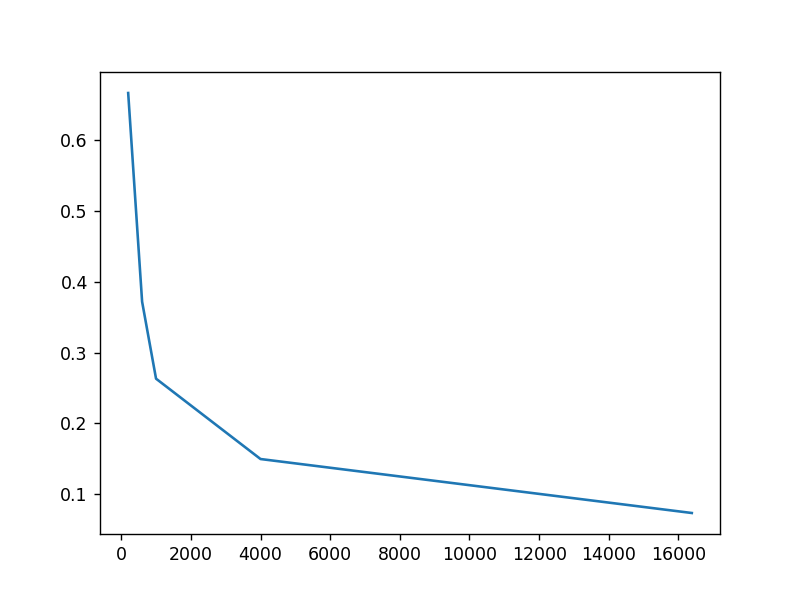

In [103]:
print(np.std(optimal_energies[4000]))
stdevs = [np.std(optimal_energies[ke]) for ke in optimal_energies.keys()]
print(stdevs + [.0738])
plt.figure(929938)
plt.plot([200,600,1000,4000,16384],stdevs + [.0738])

In [58]:
#energies = []
for k in range(5):
    print(k+1)
    algorithm_cfg = {
        'name': 'VQE',
        'operator_mode': 'matrix'
    }


    if optimizer_name == 'L_BFGS_B':
        optimizer_cfg = {
            'name': 'L_BFGS_B',
            'maxfun': maxfun
        }
    
    if optimizer_name == 'SPSA':
        optimizer_cfg = {
            'name': 'SPSA', 
            'max_trials': max_trials,
            'save_steps': 20
        }
    

    var_form_cfg = {
        'name': circuit_name,
        'depth': depth,
        'entanglement': 'linear'
    }

    backend_cfg = {
        'name': backend_name, 
        'shots': shots
    }

    params = {
        'algorithm': algorithm_cfg,
        'optimizer': optimizer_cfg,
        'variational_form': var_form_cfg,
        'backend': backend_cfg
    }

    if backend_name == 'local_statevector_simulator':
        print('SPSA STATEVECTOR predicted time to completion: {:3.1f} min'.format((2.3e-5)*shots*max_trials/60))
    
    if backend_name == 'local_qasm_simulator':
        print('SPSA QASM predicted time to completion: {:3.1f} min'.format((2.1e-4)*shots*max_trials/60))


    result_vqe = run_algorithm(params,algo_input)
    exact_energy = result_exact['energies'][0]
    vqe_energy = result_vqe['energy']
    print('Exact = {}'.format(exact_energy))
    print('VQE = {}'.format(vqe_energy))
    print('Percent Error = {:5.2f}%'.format(abs((vqe_energy-exact_energy)/exact_energy)*100))
    print('Evaluation Time = {:3.1f} min\n'.format(result_vqe['eval_time']/60)) 
    energies.append(vqe_energy)

1
SPSA QASM predicted time to completion: 1.7 min
Exact = 0.5431156684978394
VQE = 0.6504949949478238
Percent Error = 19.77%
Evaluation Time = 2.5 min

2
SPSA QASM predicted time to completion: 1.7 min
Exact = 0.5431156684978394
VQE = 0.6352500152669176
Percent Error = 16.96%
Evaluation Time = 2.5 min

3
SPSA QASM predicted time to completion: 1.7 min
Exact = 0.5431156684978394
VQE = 0.6193652799922642
Percent Error = 14.04%
Evaluation Time = 2.3 min

4
SPSA QASM predicted time to completion: 1.7 min
Exact = 0.5431156684978394
VQE = 0.48706552170418504
Percent Error = 10.32%
Evaluation Time = 2.4 min

5
SPSA QASM predicted time to completion: 1.7 min
Exact = 0.5431156684978394
VQE = 0.6161121147156035
Percent Error = 13.44%
Evaluation Time = 2.3 min



In [41]:
shots = 128
backend_name = 'local_qasm_simulator'
algorithm_cfg = {
    'name': 'QPE'
}


if optimizer_name == 'L_BFGS_B':
    optimizer_cfg = {
        'name': 'L_BFGS_B',
        'maxfun': maxfun
    }
    
if optimizer_name == 'SPSA':
    optimizer_cfg = {
        'name': 'SPSA', 
        'max_trials': max_trials,
        'save_steps': 20
    }
    

var_form_cfg = {
    'name': 'RYRZ',
    'depth': depth,
    'entanglement': 'linear'
}

backend_cfg = {
    'name': backend_name, 
    'shots': shots
}

params = {
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': backend_cfg
}

    
if backend_name == 'local_qasm_simulator':
    print('SPSA QASM predicted time to completion: {:3.1f} min'.format(((1.7e-6)*shots + 0.029)*max_trials))


result_vqe = run_algorithm(params,algo_input)
print(result_vqe)
#exact_energy = result_exact['energies'][0]
#vqe_energy = result_vqe['energy']
#print('Exact = {}'.format(exact_energy))
#print('VQE = {}'.format(vqe_energy))
#print('Percent Error = {:5.2f}%'.format(abs((vqe_energy-exact_energy)/exact_energy)*100))
#print('Evaluation Time = {:3.1f} min'.format(result_vqe['eval_time']/60)) 
# Roughly 2.3e-5 s / shot at 4 qubits and depth 3 for local_statevector_simulator. 
# Roughly 2.1e-4 s / shot at 4 qubits and depth 3 for local_qasm_simulator. Seems to scale more with loops than shots.
# 1.7e-6 min / shot, 0.029 min / loop at 4 qubits, depth 3 for local_qasm_simulator. This prediction should scale better.

SPSA QASM predicted time to completion: 5.8 min
{'translation': 71.60907167828016, 'stretch': 0.006982355563082319, 'measurements': [(128, '1')], 'top_measurement_label': '1', 'top_measurement_decimal': 0.5, 'energy': 0.0}


In [59]:
# test how error scales with shots
shotsarray2 = [400,500,600,700] 
for shots in shotsarray2:
    # Use the VQE to find the energy
    algorithm_cfg = {
        'name': 'VQE',
        'operator_mode': 'matrix'
    }


    if optimizer_name == 'L_BFGS_B':
        optimizer_cfg = {
            'name': 'L_BFGS_B',
            'maxfun': maxfun
        }
        
    if optimizer_name == 'SPSA':
        optimizer_cfg = {
            'name': 'SPSA', 
            'max_trials': max_trials,
            'save_steps': 20
        }
    

    var_form_cfg = {
        'name': 'RYRZ',
        'depth': depth,
        'entanglement': 'linear'
    }

    backend_cfg = {
        'name': backend_name, 
        'shots': shots
    }

    params = {
        'algorithm': algorithm_cfg,
        'optimizer': optimizer_cfg,
        'variational_form': var_form_cfg,
        'backend': backend_cfg
    }

    if backend_name == 'local_statevector_simulator':
        print('SPSA STATEVECTOR predicted time to completion: {:3.1f} min'.format((2.3e-5)*shots*max_trials/60))
    
    if backend_name == 'local_qasm_simulator':
        print('SPSA QASM predicted time to completion: {:3.1f} min'.format(((6e-5)*shots + 0.036)*max_trials))


    result_vqe = run_algorithm(params,algo_input)
    exact_energy = result_exact['energies'][0]
    vqe_energy = result_vqe['energy']
    print('Shots = {}'.format(shots))
    print('Exact = {}'.format(exact_energy))
    print('VQE = {}'.format(vqe_energy))
    print('Percent Error = {:5.2f}%'.format(abs((vqe_energy-exact_energy)/exact_energy)*100))
    print('Evaluation Time = {:3.1f} min'.format(result_vqe['eval_time']/60)) 
    pct_error.append(abs((vqe_energy-exact_energy)/exact_energy)*100)
    energies.append(vqe_energy)
    shotsarray.append(shots)
# Roughly 2.3e-5 s / shot at 4 qubits and depth 3 for local_statevector_simulator. 
# Roughly 2.1e-4 s / shot at 4 qubits and depth 3 for local_qasm_simulator. Seems to scale more with loops than shots.
# 1.7e-6 min / shot, 0.029 min / loop at 4 qubits, depth 3 for local_qasm_simulator. This prediction should scale better.

# stuff already determined manually
#shotsarray.append(128)
#pct_error.append(116.84)
#energies.append(1.178)
#shotsarray.append(256)
#pct_error.append(.65)
#energies.append(.547)
#shotsarray.append(512)
#pct_error.append(17.15)
#energies.append(.4499)
#shotsarray.append(1024)
#pct_error.append(69.55)
#energies.append(.921)
#shotsarray.append(16384) # this took an hour
#pct_error.append(72.68)
#energies.append(.93787)

SPSA QASM predicted time to completion: 12.0 min
Shots = 400
Exact = 0.5431156684978454
VQE = 2.1412275871996833
Percent Error = 294.25%
Evaluation Time = 9.4 min
SPSA QASM predicted time to completion: 13.2 min
Shots = 500
Exact = 0.5431156684978454
VQE = 2.5525559565028964
Percent Error = 369.98%
Evaluation Time = 9.4 min
SPSA QASM predicted time to completion: 14.4 min
Shots = 600
Exact = 0.5431156684978454
VQE = 1.0709632253394261
Percent Error = 97.19%
Evaluation Time = 10.9 min
SPSA QASM predicted time to completion: 15.6 min
Shots = 700
Exact = 0.5431156684978454
VQE = 1.31286448281182
Percent Error = 141.73%
Evaluation Time = 11.0 min


<IPython.core.display.Javascript object>


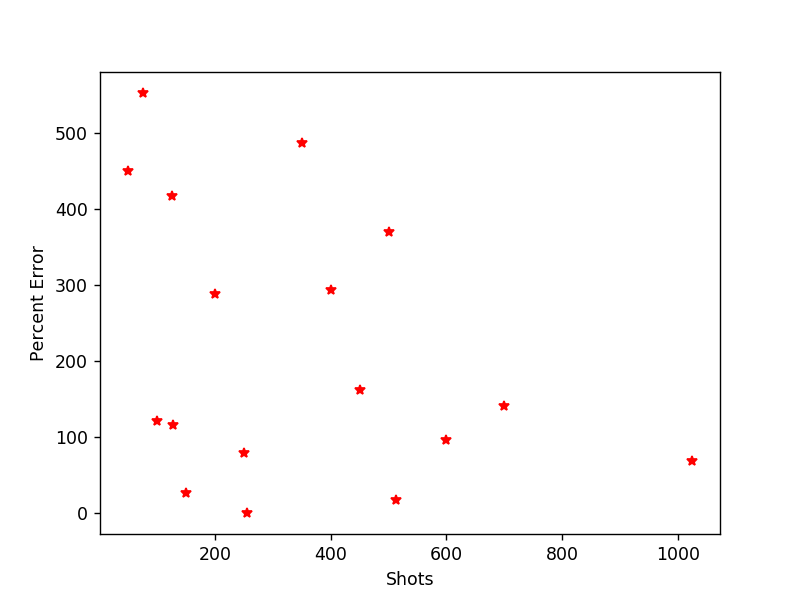

<IPython.core.display.Javascript object>


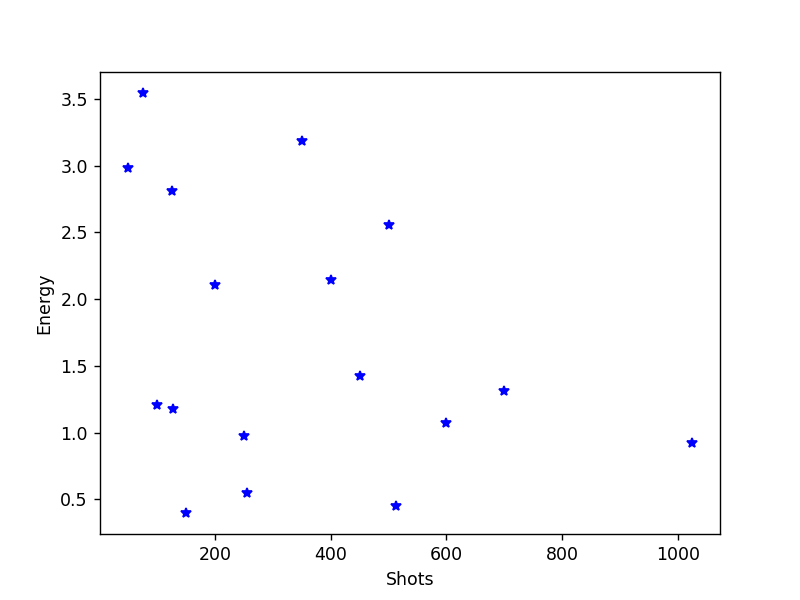

In [62]:
plt.figure(456)
plt.plot(sum([shotsarray[:-5],shotsarray[-4:]],[]),sum([pct_error[:-5],pct_error[-4:]],[]),'r*')
plt.xlabel('Shots')
plt.ylabel('Percent Error')
plt.show()
plt.figure(567)
plt.plot(sum([shotsarray[:-5],shotsarray[-4:]],[]),sum([energies[:-5],energies[-4:]],[]),'b*')
plt.xlabel('Shots')
plt.ylabel('Energy')
plt.show()

In [61]:
print(shotsarray)
print(energies)
print(pct_error)

[50, 75, 100, 125, 150, 200, 250, 350, 450, 128, 256, 512, 1024, 16384, 400, 500, 600, 700]
[2.986460427327774, 3.545109652401802, 1.203716462349469, 2.808142210149784, 0.39685972066193287, 2.1091270957949675, 0.9721289231138908, 3.188682076633624, 1.4238424017052527, 1.178, 0.547, 0.4499, 0.921, 0.93787, 2.1412275871996833, 2.5525559565028964, 1.0709632253394261, 1.31286448281182]
[449.8755790986026, 552.7356616698061, 121.63169508232372, 417.0431223088391, 26.929060662239536, 288.3384733915727, 78.99113936495597, 487.1092037268805, 162.1619084647898, 116.84, 0.65, 17.15, 69.55, 72.68, 294.24890707386726, 369.98385510820935, 97.18879190164161, 141.72833872441083]


In [58]:
print(shotsarray)
print(energies)
print(pct_error)

[50, 75, 100, 125, 150, 200, 250, 350, 450, 128, 256, 512, 1024, 16384]
[2.986460427327774, 3.545109652401802, 1.203716462349469, 2.808142210149784, 0.39685972066193287, 2.1091270957949675, 0.9721289231138908, 3.188682076633624, 1.4238424017052527, 1.178, 0.547, 0.4499, 0.921, 0.93787]
[449.8755790986026, 552.7356616698061, 121.63169508232372, 417.0431223088391, 26.929060662239536, 288.3384733915727, 78.99113936495597, 487.1092037268805, 162.1619084647898, 116.84, 0.65, 17.15, 69.55, 72.68]
